In [ ]:
#import all necessary libraries
import mediapipe as mp
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import json
import pandas as pd
import shutil
import random
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
import time
from pathlib import Path
import keras
import tensorflow as tf
import csv
import re
import random
from PIL import Image


## Split Data

In [ ]:
#split data
source_folder = "D:/asl/video/train"  # Path to the source folder
destination_folder = "D:/asl/video/test"  # Path to the destination folder

# Iterate through each subfolder in the source folder
for root, dirs, files in os.walk(source_folder):
    for directory in dirs:
        files_to_move = os.listdir(root+"/"+ directory)
        random.shuffle(files_to_move)  # Shuffle the files

        # Calculate 20% of the files to move
        num_files_to_move = int(len(files_to_move) * 0.20)

        # Select 20% of the files
        files_to_move = files_to_move[:num_files_to_move]

        # Create the destination subfolder if it doesn't exist
        destination_subfolder =destination_folder+"/"+directory
        os.makedirs(destination_subfolder, exist_ok=True)

        # Move the selected files to the destination subfolder
        for file in files_to_move:
            source_file = os.path.join(root, directory, file)
            destination_file = os.path.join(destination_subfolder, file)
            shutil.move(source_file, destination_file)
            print(destination_file)

## Data Preprocessing- Augmentation, Cleaning

In [ ]:
def rotation(img, angle):
    #angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [ ]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import cv2

def data_augmentation(video, savepath):    
     
    cap = cv2.VideoCapture(video)
    fname= video.split("/")[-1]
    gloss= fname.split("_")[0]
   

    frame_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get width and height
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps= int(cap.get(cv2.CAP_PROP_FPS))
    newvideoR = cv2.VideoWriter(savepath, cv2.VideoWriter_fourcc(*"mp4v"), fps, (frame_width, frame_height))
    
    # Original Frames
    #frames = []
    hflip=iaa.Fliplr(p=1) #label a #lsa label a
    vflip=iaa.Flipud(p=1) #label g
    #repeat, label r
    #blur
    blur = iaa.AverageBlur(k=(2, 2)) #label e (only apply to label a) 
    #crop
    crop = iaa.Crop(percent=(0.01, 0.01))#labelb(0.02), c(0.03), d(0.05), f(0.01) #label b(0.01) c(0.01) d(none) e(none)
    #sigmoid contrast
    contrast_sig = iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6), per_channel=True)
    #linear contrast
    contrast_lin = iaa.LinearContrast((0.6, 0.4))#label 
    blurb= iaa.blur.GaussianBlur()#label
    for i in range(frame_number):
        ret, frame = cap.read()
        new =rotation(frame, 30)
        cv2.imshow('output', new)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        newvideoR.write(new)
    print(savepath)
    newvideoR.release()
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
folder="D:/lsa/mediapipe/val"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for vid in os.listdir(filepath):
        if vid.endswith(".mp4"):
    #             idx= vid.split("_")[-1]
            vidname=vid.split(".")[0]
    #             gloss= vid.split("_")[0]
    #             if re.match(r'^\d+$', idx):
            vidpath= filepath+"/"+vid
            savepath= filepath+"/"+vidname+"c.mp4"
            try:
                data_augmentation(vidpath, savepath)
                print(savepath)
            except:
                print(vid, 'fail')

In [ ]:
#check raw video length, width, height and fps
#to get frame count of all videos
def getFrameCount(file):
    """
    get video length, height, width

    Args:
    file: file path

    return:
    video length, height and width

    """
    #allVideoLength=[]
    #for file in os.listdir(path):
    #     if file.endswith(".mp4"):
    #        path=os.path.join(path, file)
    cap=cv2.VideoCapture(file)
    length= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps= int(cap.get(cv2.CAP_PROP_FPS))
            #allVideoLength.append(length)
            #while cap.isOpened():
            #    ret, image= cap.read()
            #    print(image.shape)
    return length

In [ ]:
path="D:/asl/video/train"
counts=[]
for folder in os.listdir(path):
    folderpath= path+"/"+folder
    for vid in os.listdir(folderpath):
        if vid.endswith('mp4'):
            filename= vid.split("/")[-1]
            idx= filename.split(".")[0]
            idxnum= idx.split("_")[-1]
            if idxnum.isdigit()==True:
                vidpath= folderpath+"/"+vid
                count=getFrameCount(vidpath)
                counts.append(count)
                
sorted(counts)

In [ ]:
# generate bounding box
df= pd.read_csv("D:/WASL/gloss.csv")
vidId=df['video_id'].tolist()
newvidId=[]
for i in vidId:
    i=str(i)
    if len(i)< 5:
        newid="{:05}".format(int(i))
        newvidId.append(newid)
        df['filename']=str(newid)+".mp4"
    else:
        newvidId.append(i)
        df['filename']=i
bbox=df['bbox'].tolist()
bboxDict= dict(zip(newvidId, bbox))

### Mediapipe Holistic Solution

In [ ]:
mp_holistic= mp.solutions.holistic
mp_drawing= mp.solutions.drawing_utils

In [ ]:
def draw_landmarks_style(image, results, size):
    
    if size >(1000,1000):
        
        #draw the pose landmarks
        mp_drawing.draw_landmarks(image,
           results.pose_landmarks,
           mp_holistic.POSE_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(0,255,255), thickness=12, circle_radius=5),
           mp_drawing.DrawingSpec(color=(255,255,255), thickness=12, circle_radius=5))


        #draw right hand landmarks
        mp_drawing.draw_landmarks(image,
           results.right_hand_landmarks,
           mp_holistic.HAND_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(194, 24, 91), thickness=12, circle_radius=5),#pink
           mp_drawing.DrawingSpec(color=(186, 104, 200), thickness=12, circle_radius=5))#light pink


        #draw left hand landmarks
        mp_drawing.draw_landmarks(image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(139, 195, 74), thickness=12, circle_radius=5),#green
            mp_drawing.DrawingSpec(color=(249, 168, 37), thickness=12, circle_radius=5)) #orange


    elif size<(300,350):
       
        #draw the pose landmarks
        mp_drawing.draw_landmarks(image,
           results.pose_landmarks,
           mp_holistic.POSE_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=1),
           mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=1))


        #draw right hand landmarks
        mp_drawing.draw_landmarks(image,
           results.right_hand_landmarks,
           mp_holistic.HAND_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(194, 24, 91), thickness=2, circle_radius=1),
           mp_drawing.DrawingSpec(color=(186, 104, 200), thickness=2, circle_radius=1))


        #draw left hand landmarks
        mp_drawing.draw_landmarks(image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(139, 195, 74), thickness=2, circle_radius=1),
            mp_drawing.DrawingSpec(color=(249, 168, 37), thickness=2, circle_radius=1))
    
    elif size>(700,1000) and size <(1000,1300):
       
        #draw the pose landmarks
        mp_drawing.draw_landmarks(image,
           results.pose_landmarks,
           mp_holistic.POSE_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(0,255,255), thickness=5, circle_radius=1),
           mp_drawing.DrawingSpec(color=(255,255,255), thickness=5, circle_radius=1))


        #draw right hand landmarks
        mp_drawing.draw_landmarks(image,
           results.right_hand_landmarks,
           mp_holistic.HAND_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(194, 24, 91), thickness=5, circle_radius=1),
           mp_drawing.DrawingSpec(color=(186, 104, 200), thickness=5, circle_radius=1))


        #draw left hand landmarks
        mp_drawing.draw_landmarks(image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(139, 195, 74), thickness=5, circle_radius=1),
            mp_drawing.DrawingSpec(color=(249, 168, 37), thickness=5, circle_radius=1))
        
    elif size==(400,720):
        #draw the pose landmarks
        mp_drawing.draw_landmarks(image,
           results.pose_landmarks,
           mp_holistic.POSE_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=1),
           mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=1))


        #draw right hand landmarks
        mp_drawing.draw_landmarks(image,
           results.right_hand_landmarks,
           mp_holistic.HAND_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(194, 24, 91), thickness=2, circle_radius=1),
           mp_drawing.DrawingSpec(color=(186, 104, 200), thickness=2, circle_radius=1))


        #draw left hand landmarks
        mp_drawing.draw_landmarks(image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(139, 195, 74), thickness=2, circle_radius=1),
            mp_drawing.DrawingSpec(color=(249, 168, 37), thickness=2, circle_radius=1))

    else:
        #draw the pose landmarks
        mp_drawing.draw_landmarks(image,
           results.pose_landmarks,
           mp_holistic.POSE_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(0,255,255), thickness=3, circle_radius=1),
           mp_drawing.DrawingSpec(color=(255,255,255), thickness=3, circle_radius=1))


        #draw right hand landmarks
        mp_drawing.draw_landmarks(image,
           results.right_hand_landmarks,
           mp_holistic.HAND_CONNECTIONS,
           mp_drawing.DrawingSpec(color=(194, 24, 91), thickness=3, circle_radius=1),
           mp_drawing.DrawingSpec(color=(186, 104, 200), thickness=3, circle_radius=1))


        #draw left hand landmarks
        mp_drawing.draw_landmarks(image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(139, 195, 74), thickness=3, circle_radius=1),
            mp_drawing.DrawingSpec(color=(249, 168, 37), thickness=3, circle_radius=1))
   

In [ ]:
#create function to extract 3D key points

def extract_keypoints(results):

    pose= np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    lh= np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh= np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])


In [ ]:
#calculate the distance between different joints of hands for additional features
def distance_between(p1, p2, lmk):
    p1=p1*2
    p2=p2*2
    x1, y1= lmk[p1:p1+2]
    x2, y2= lmk[p2:p2+2]
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
def landmark_to_dist_emb(lmk, lmk2):
    
    distance = np.array([
    #thumb to finger tip
    distance_between(4,8,lmk),
    distance_between(4,12,lmk),
    distance_between(4,16,lmk),
    distance_between(4,20,lmk),
    #wrist to finger tip
    distance_between(4,0,lmk),
    distance_between(8,0,lmk),
    distance_between(12,0,lmk),
    distance_between(16,0,lmk),
    distance_between(20,0,lmk),
    #tip to tip (specific to this application)
    distance_between(8,12,lmk),
    distance_between(12,16,lmk),
    distance_between (16,20,lmk),
    #within finger joint (detect bending)
    distance_between(1,4,lmk),
    distance_between(8,5,lmk),
    distance_between(12,9,lmk),
    distance_between(16,13,lmk),
    distance_between(20,17,lmk),
    #distance from each tip to thumb joint
    distance_between(2,8,lmk),
    distance_between(2,12,lmk),
    distance_between(2,16,lmk),
    distance_between(2,20,lmk)
    ])
    shoulder= distance_between(12,11, lmk2)
    
    #use np normalize, as min_max may create confusion that the closest fingers has 0 distance
    #distance_norm = distance / np.linalg.norm(distance)
    distance_norm= distance/shoulder
    distance_norm[np.isnan(distance_norm)] = 0
    return distance_norm

In [ ]:
#create function to extract keypoints

import math

def all_keypoints(video_path, frame_num):
    
    all_data=[]
    not_flatten=[]
    frames=list(range(0, frame_num))
    all_data=[]
    cap= cv2.VideoCapture(video_path)
    #frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # get width of input video
    width= int(cap.get(3))
    # get height of input video
    height= int(cap.get(4))
    size= (width, height)
#     #extract class name
#     classname= video_path.split("/")[-2]
#     classcategory= class_ids[classname]
    
    #save path
    mainpath="D:/lsa/keypoints/test"
    classfile= video_path.split("/")[-2:]
    filename= classfile[1].split(".")[0]
    newpath= mainpath+"/"+classfile[0]+"/"+filename+".npy"
    print(newpath)

    with mp_holistic.Holistic(min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as holistic:

        while cap.isOpened():
            ret, image= cap.read()
            if not ret:
                break
            image.flags.writeable=False
            results= holistic.process(image)
            #draw landmark annotation on the frame.
            image.flags.writeable= True
            draw_landmarks_style(image, results, size)

            #extract keypoints
            keypoints= extract_keypoints(results)#to extract pose, left hand and right hand landmarks 
            pose= np.array([[res.x, res.y] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*2)   
            lh= np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
            rh= np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
          
            lh_dist=np.array(landmark_to_dist_emb(lh, pose)).flatten()
            #print(len(lh_dist))
            rh_dist=np.array(landmark_to_dist_emb(rh, pose)).flatten()
            #print(len(rh_dist))
            data= np.concatenate([keypoints, lh_dist, rh_dist])
            total_len= len(keypoints)+len(rh_dist)+ len(lh_dist)
            all_data.append(data)
        

            cv2.imshow('output', image)
            if cv2.waitKey(5) & 0xFF == 27:
                break
        
    print(total_len)
    if len(all_data)>frame_num:
        all_data=all_data[:frame_num]

    elif len(all_data)<frame_num:
        while len(all_data) < frame_num:
            all_data.append(all_data[-1])
    else:
        all_data= all_data
    
    all_data=all_data[10:]
    np.save(newpath, all_data)
    cap.release()
    cv2.destroyAllWindows()
    return all_data
    
    

In [ ]:
rawvideopath= "D:/lsa/video2/test2"
for file in os.listdir(rawvideopath):
    filepath= rawvideopath+"/"+ file
    for vid in os.listdir(filepath):
        vidpath= filepath+"/"+vid
        print(vidpath)
        try:
            all_keypoints(vidpath, 200)
        except:
             print(vidpath, 'fail')

## create label

In [42]:
import tensorflow as tf
trainPath= "D:/asl/keypoints/train15"
glossLst=[]
#total unique gloss
for file in os.listdir(trainPath):
    glossLst.append(file)
    
glossLst= sorted(glossLst)
print(glossLst)

#perform one-hot encoding in glosses
idxarray=tf.keras.utils.to_categorical([i for i in range(len(glossLst))], num_classes=15)
class_ids=dict(zip(glossLst, idxarray))
class_ids

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/asl/keypoints/train15'

## Frame Generator

In [2]:
def format_frames(frame, output_size):
    frame= tf.image.convert_image_dtype(frame, tf.float32)
    frame= tf.image.resize_with_pad(frame, *output_size)

    return frame

In [3]:
def frames_from_video_file(video_path, n_frames, output_size, frame_step = 8):
  
  # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(video_path)

    src.set(cv2.CAP_PROP_POS_MSEC, 500)
      # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
        
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result


In [ ]:
test= frames_from_video_file(r"D:\asl\mediapipe\train\after\after_01420acd.mp4",
                          n_frames=8, output_size=(200,200), frame_step=8)

In [ ]:
#240,272 ori(240, 320)
from matplotlib import pyplot as plt
for i in range(len(test)):
    print(len(test))
    plt.imshow(test[i], interpolation='nearest')
    plt.show()

In [5]:
train_sequences, train_labels=[], []
folder="D:/asl/keypoints/train15"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for af in os.listdir(filepath):
        if af.endswith("npy"):
            apath= filepath+"/"+af
            res= np.load(apath)
            train_sequences.append(res)
            train_labels.append(class_ids[file])
            

In [6]:
x_train=np.array(train_sequences)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))

In [8]:
val_sequences, val_labels=[], []
folder="D:/asl/keypoints/val15"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for af in os.listdir(filepath):
        if af.endswith("npy"):
            apath= filepath+"/"+af
            res= np.load(apath)
            val_sequences.append(res)
            val_labels.append(class_ids[file])

In [9]:
x_val=np.array(val_sequences)

In [10]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [12]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 145, 267), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [13]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 145, 267), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [14]:
test_sequences, test_labels=[], []
folder= "D:/asl/keypoints/test15"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for af in os.listdir(filepath):
        if af.endswith("npy"):
            apath= filepath+"/"+af
            res= np.load(apath)
            test_sequences.append(res)
            test_labels.append(class_ids[file])

In [15]:
x_test=np.array(test_sequences)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))

In [16]:
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 145, 267), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

### Model 1- ConvLSTM

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D, Activation, Input
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import LayerNormalization
from keras import initializers

In [20]:
model= Sequential()
model.add(Input(shape=(145, 267)))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(SeqSelfAttention(attention_activation='sigmoid',
                        kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

C:\Users\TSL\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 145, 32)           25664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 48, 64)            24832     
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 batch_normalization (Batch  (None, 48, 64)            256       
 Normalization)                                         

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=1.0)

def lrSchedule(epoch):
    lr  = 0.0001
    if epoch < 50:
        lr = 0.001
        
    print('Learning rate: ', lr)
    return lr
LRScheduler= LearningRateScheduler(lrSchedule)

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss= tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [26]:
#splitting train-val
lstm_result=model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[callback])

Epoch 1/200
245/245 [==============================] - 109s 272ms/step - loss: 2.8290 - accuracy: 0.1125 - val_loss: 2.7737 - val_accuracy: 0.0778
Epoch 2/200
245/245 [==============================] - 56s 226ms/step - loss: 2.6450 - accuracy: 0.1772 - val_loss: 2.6400 - val_accuracy: 0.1875
Epoch 3/200
245/245 [==============================] - 57s 233ms/step - loss: 2.4945 - accuracy: 0.2211 - val_loss: 2.5808 - val_accuracy: 0.1424
Epoch 4/200
245/245 [==============================] - 58s 236ms/step - loss: 2.3616 - accuracy: 0.2604 - val_loss: 2.4852 - val_accuracy: 0.1653
Epoch 5/200
245/245 [==============================] - 58s 236ms/step - loss: 2.2230 - accuracy: 0.2894 - val_loss: 2.4238 - val_accuracy: 0.2340
Epoch 6/200
245/245 [==============================] - 57s 231ms/step - loss: 2.1036 - accuracy: 0.3276 - val_loss: 2.3538 - val_accuracy: 0.2556
Epoch 7/200
245/245 [==============================] - 56s 230ms/step - loss: 1.9970 - accuracy: 0.3515 - val_loss: 2.3284 

Epoch 57/200
245/245 [==============================] - 43s 176ms/step - loss: 0.2775 - accuracy: 0.9326 - val_loss: 1.8002 - val_accuracy: 0.5875
Epoch 58/200
245/245 [==============================] - 43s 177ms/step - loss: 0.2734 - accuracy: 0.9337 - val_loss: 1.7554 - val_accuracy: 0.6090
Epoch 59/200
245/245 [==============================] - 43s 177ms/step - loss: 0.2407 - accuracy: 0.9430 - val_loss: 1.7854 - val_accuracy: 0.5972
Epoch 60/200
245/245 [==============================] - 44s 179ms/step - loss: 0.2529 - accuracy: 0.9384 - val_loss: 1.8010 - val_accuracy: 0.5979
Epoch 61/200
245/245 [==============================] - 43s 176ms/step - loss: 0.2476 - accuracy: 0.9423 - val_loss: 1.8532 - val_accuracy: 0.5917
Epoch 62/200
245/245 [==============================] - 44s 178ms/step - loss: 0.2390 - accuracy: 0.9426 - val_loss: 1.8394 - val_accuracy: 0.5931
Epoch 63/200
245/245 [==============================] - 43s 176ms/step - loss: 0.2206 - accuracy: 0.9499 - val_loss: 1

245/245 [==============================] - 44s 178ms/step - loss: 0.0360 - accuracy: 0.9941 - val_loss: 2.2813 - val_accuracy: 0.5896
Epoch 168/200
245/245 [==============================] - 45s 182ms/step - loss: 0.0333 - accuracy: 0.9935 - val_loss: 2.3746 - val_accuracy: 0.5479
Epoch 169/200
245/245 [==============================] - 44s 180ms/step - loss: 0.0367 - accuracy: 0.9930 - val_loss: 2.2087 - val_accuracy: 0.5813
Epoch 170/200
245/245 [==============================] - 44s 178ms/step - loss: 0.0375 - accuracy: 0.9929 - val_loss: 2.5491 - val_accuracy: 0.5375
Epoch 171/200
245/245 [==============================] - 44s 179ms/step - loss: 0.0367 - accuracy: 0.9920 - val_loss: 2.0364 - val_accuracy: 0.5972
Epoch 172/200
245/245 [==============================] - 44s 177ms/step - loss: 0.0338 - accuracy: 0.9939 - val_loss: 2.2960 - val_accuracy: 0.5507
Epoch 173/200
245/245 [==============================] - 43s 177ms/step - loss: 0.0393 - accuracy: 0.9906 - val_loss: 2.2406 -

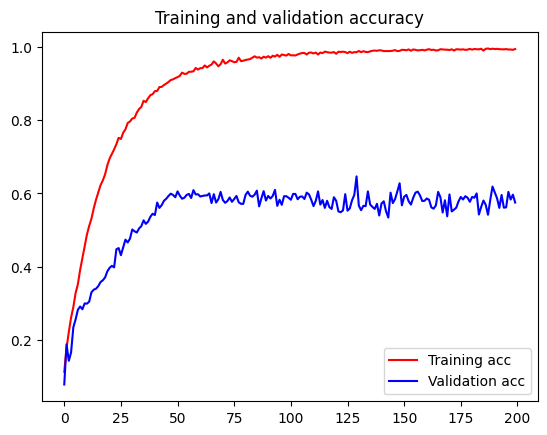

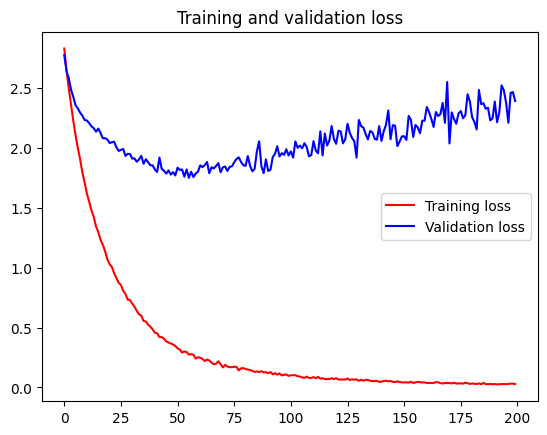

In [27]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = lstm_result.history['accuracy']
val_acc = lstm_result.history['val_accuracy']
loss = lstm_result.history['loss']
val_loss = lstm_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
#evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)

1/1 [==============================] - 0s 106ms/step - loss: 5.2784 - accuracy: 0.6000


In [29]:
from sklearn.metrics import confusion_matrix

# Access the ground truth labels
true_labels = test_labels
true_labels = np.argmax(test_labels, axis=1)
#confusion matrix
# Make predictions on the test data
predictions = model.predict(test_dataset)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes
# true_classes = np.array(true_labels)

# from sklearn.metrics import confusion_matrix
confusion_lstm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_lstm)

1/1 [==============================] - 4s 4s/step
Confusion Matrix:
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


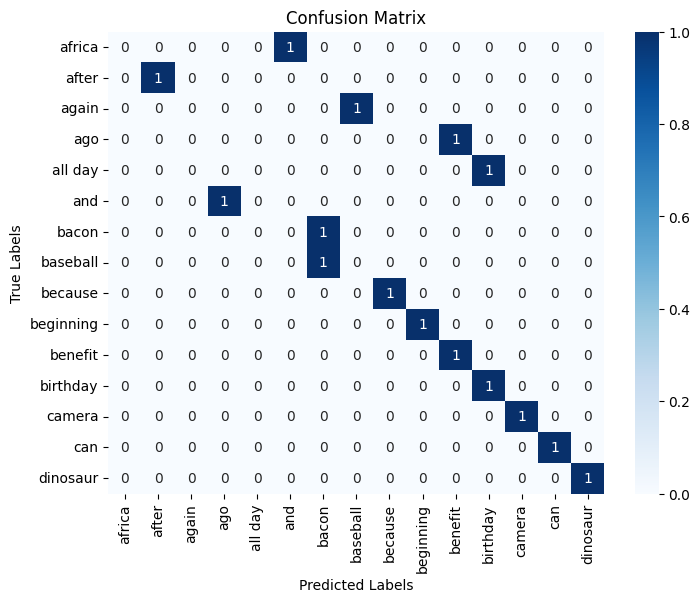

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_lstm, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

      africa       0.00      0.00      0.00         1
       after       1.00      1.00      1.00         1
       again       0.00      0.00      0.00         1
         ago       0.00      0.00      0.00         1
     all day       0.00      0.00      0.00         1
         and       0.00      0.00      0.00         1
       bacon       0.50      1.00      0.67         1
    baseball       0.00      0.00      0.00         1
     because       1.00      1.00      1.00         1
   beginning       1.00      1.00      1.00         1
     benefit       0.50      1.00      0.67         1
    birthday       0.50      1.00      0.67         1
      camera       1.00      1.00      1.00         1
         can       1.00      1.00      1.00         1
    dinosaur       1.00      1.00      1.00         1

    accuracy                           0.60        15
   macro avg       0.50      0.60      0.53        15
weighted avg       0.50   

C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 2 Conv-GRU

In [31]:
gru= Sequential()
gru.add(Input(shape=(145, 267)))
gru.add(Conv1D(32, 3, padding='same', activation='relu'))
gru.add(MaxPooling1D(3))
gru.add(Dropout(0.3))
gru.add(GRU(64, return_sequences=True))
gru.add(Dropout(0.5))
gru.add(BatchNormalization())
gru.add(GRU(128, return_sequences=True))
gru.add(Dropout(0.5))
gru.add(BatchNormalization())
gru.add(SeqSelfAttention(attention_activation='sigmoid',
                        kernel_regularizer=keras.regularizers.l2(0.001)))
gru.add(Flatten())
gru.add(Dense(15, activation='softmax'))

In [32]:
gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 145, 32)           25664     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 48, 32)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 48, 32)            0         
                                                                 
 gru (GRU)                   (None, 48, 64)            18816     
                                                                 
 dropout_4 (Dropout)         (None, 48, 64)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 48, 64)            256       
 chNormalization)                                     

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=1.0) 

def lrSchedule(epoch):
    lr  = 0.0001
    if epoch < 10:
        lr = 0.001
        
    print('Learning rate: ', lr)
    return lr
LRScheduler= LearningRateScheduler(lrSchedule)

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
gru.compile(optimizer=opt, loss= tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [35]:
gru_result=gru.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[callback])

Epoch 1/200
245/245 [==============================] - 73s 194ms/step - loss: 2.8094 - accuracy: 0.1113 - val_loss: 2.8098 - val_accuracy: 0.0847
Epoch 2/200
245/245 [==============================] - 44s 180ms/step - loss: 2.6731 - accuracy: 0.1642 - val_loss: 2.7297 - val_accuracy: 0.0799
Epoch 3/200
245/245 [==============================] - 43s 176ms/step - loss: 2.5559 - accuracy: 0.2044 - val_loss: 2.5869 - val_accuracy: 0.1299
Epoch 4/200
245/245 [==============================] - 43s 177ms/step - loss: 2.4227 - accuracy: 0.2531 - val_loss: 2.4528 - val_accuracy: 0.1722
Epoch 5/200
245/245 [==============================] - 44s 180ms/step - loss: 2.2898 - accuracy: 0.2876 - val_loss: 2.3403 - val_accuracy: 0.2104
Epoch 6/200
245/245 [==============================] - 44s 177ms/step - loss: 2.1598 - accuracy: 0.3294 - val_loss: 2.2368 - val_accuracy: 0.2243
Epoch 7/200
245/245 [==============================] - 45s 184ms/step - loss: 2.0372 - accuracy: 0.3492 - val_loss: 2.1809 -

Epoch 57/200
245/245 [==============================] - 45s 183ms/step - loss: 0.3523 - accuracy: 0.9072 - val_loss: 2.0382 - val_accuracy: 0.4764
Epoch 58/200
245/245 [==============================] - 45s 182ms/step - loss: 0.3584 - accuracy: 0.9089 - val_loss: 2.0402 - val_accuracy: 0.4993
Epoch 59/200
245/245 [==============================] - 45s 184ms/step - loss: 0.3293 - accuracy: 0.9135 - val_loss: 2.0561 - val_accuracy: 0.4965
Epoch 60/200
245/245 [==============================] - 45s 182ms/step - loss: 0.3315 - accuracy: 0.9139 - val_loss: 2.0536 - val_accuracy: 0.4826
Epoch 61/200
245/245 [==============================] - 45s 182ms/step - loss: 0.3110 - accuracy: 0.9197 - val_loss: 2.1005 - val_accuracy: 0.4785
Epoch 62/200
245/245 [==============================] - 45s 184ms/step - loss: 0.3167 - accuracy: 0.9173 - val_loss: 2.0434 - val_accuracy: 0.5111
Epoch 63/200
245/245 [==============================] - 45s 184ms/step - loss: 0.3194 - accuracy: 0.9163 - val_loss: 1

245/245 [==============================] - 45s 184ms/step - loss: 0.0734 - accuracy: 0.9818 - val_loss: 1.7644 - val_accuracy: 0.5590
Epoch 168/200
245/245 [==============================] - 45s 183ms/step - loss: 0.0662 - accuracy: 0.9858 - val_loss: 1.9787 - val_accuracy: 0.5847
Epoch 169/200
245/245 [==============================] - 45s 182ms/step - loss: 0.0717 - accuracy: 0.9828 - val_loss: 1.9285 - val_accuracy: 0.6028
Epoch 170/200
245/245 [==============================] - 45s 183ms/step - loss: 0.0661 - accuracy: 0.9838 - val_loss: 1.9492 - val_accuracy: 0.6069
Epoch 171/200
245/245 [==============================] - 45s 182ms/step - loss: 0.0719 - accuracy: 0.9852 - val_loss: 1.8349 - val_accuracy: 0.5813
Epoch 172/200
245/245 [==============================] - 45s 183ms/step - loss: 0.0706 - accuracy: 0.9846 - val_loss: 1.9515 - val_accuracy: 0.5757
Epoch 173/200
245/245 [==============================] - 45s 182ms/step - loss: 0.0595 - accuracy: 0.9872 - val_loss: 1.8747 -

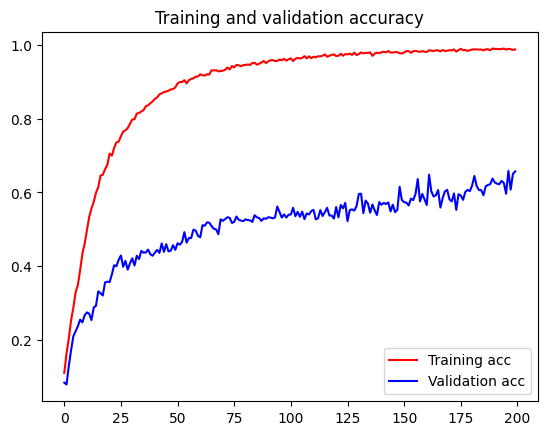

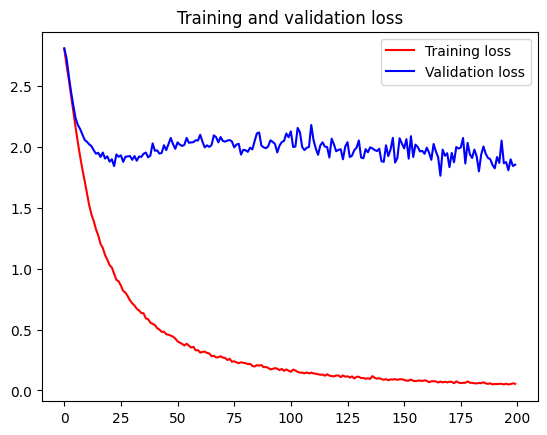

In [36]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = gru_result.history['accuracy']
val_acc = gru_result.history['val_accuracy']
loss = gru_result.history['loss']
val_loss = gru_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
#evaluate on test set
test_loss, test_accuracy = gru.evaluate(test_dataset)

1/1 [==============================] - 0s 82ms/step - loss: 2.8769 - accuracy: 0.6667


In [39]:
from sklearn.metrics import confusion_matrix
# Access the ground truth labels
true_labels = test_labels
true_labels = np.argmax(test_labels, axis=1)
#confusion matrix
# Make predictions on the test data
predictions = gru.predict(test_dataset)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes
# true_classes = np.array(true_labels)

# from sklearn.metrics import confusion_matrix
confusion_gru = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_gru)

1/1 [==============================] - 0s 37ms/step
Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


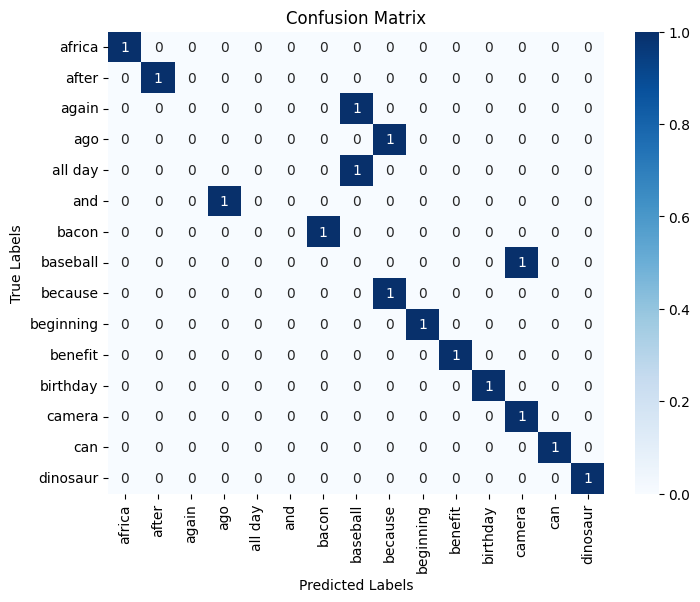

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_gru, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

      africa       1.00      1.00      1.00         1
       after       1.00      1.00      1.00         1
       again       0.00      0.00      0.00         1
         ago       0.00      0.00      0.00         1
     all day       0.00      0.00      0.00         1
         and       0.00      0.00      0.00         1
       bacon       1.00      1.00      1.00         1
    baseball       0.00      0.00      0.00         1
     because       0.50      1.00      0.67         1
   beginning       1.00      1.00      1.00         1
     benefit       1.00      1.00      1.00         1
    birthday       1.00      1.00      1.00         1
      camera       0.50      1.00      0.67         1
         can       1.00      1.00      1.00         1
    dinosaur       1.00      1.00      1.00         1

    accuracy                           0.67        15
   macro avg       0.60      0.67      0.62        15
weighted avg       0.60   

C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
